# Рекомендательная система видеоигр

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## EDA

Данные взяты из источника: https://nijianmo.github.io/amazon/index.html  

Конкретно был взят сжатый датасет видоигр (Small Video Games ratings only), который содержит:

* ID видеоигры
* ID пользователя
* оценка игры пользователем
* время. 

In [13]:
df = pd.read_csv(r'data/video_games.csv', names=['item','user','rating','timestamp'], index_col='timestamp').sort_index()

In [3]:
df.head()

,item,user,rating
timestamp,,,
878947200,B00000JL6V,AR9HFLYSXUOYS,5.0
880761600,B00000JL6V,A26Y5BK10TL1OI,5.0
881884800,B00000JL6V,A3VMPX6KW6VSQY,5.0
882057600,B00000JL6V,A3N83WBSOG9PE4,1.0
882230400,B00000JL6V,A2Q6FRINMH0R81,4.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2565349 entries, 878947200 to 1538438400
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   item    object 
 1   user    object 
 2   rating  float64
dtypes: float64(1), object(2)
memory usage: 78.3+ MB


In [5]:
df.duplicated().any()

True

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.isnull().any()

item      False
user      False
rating    False
dtype: bool

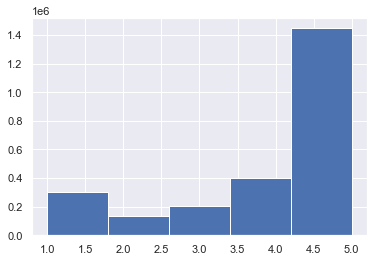

In [8]:
df.rating = df.rating.astype('ubyte')
df.rating.hist(bins=5)

Средний рейтинг и количество оценок для каждой игры

In [9]:
df.groupby(['item']).rating.agg(['mean', 'count']).sort_values(['mean', 'count'], ascending=False)

,mean,count
item,,
B00104UBY0,5.0,335
B00S7HYEKK,5.0,25
B0186D1UW4,5.0,25
B000SMMOFO,5.0,21
B00GXYECL0,5.0,21
...,...,...
B01H72SGRC,1.0,1
B01HBP8QHA,1.0,1
B01HCAW0TE,1.0,1


Далее фильтруем пользователей и товары, чтобы матрица была менее разреженной

In [10]:
item_user = df.groupby('item')['user'].count()
user_item = df.groupby('user')['item'].count()

Распределение игр от количества оценок

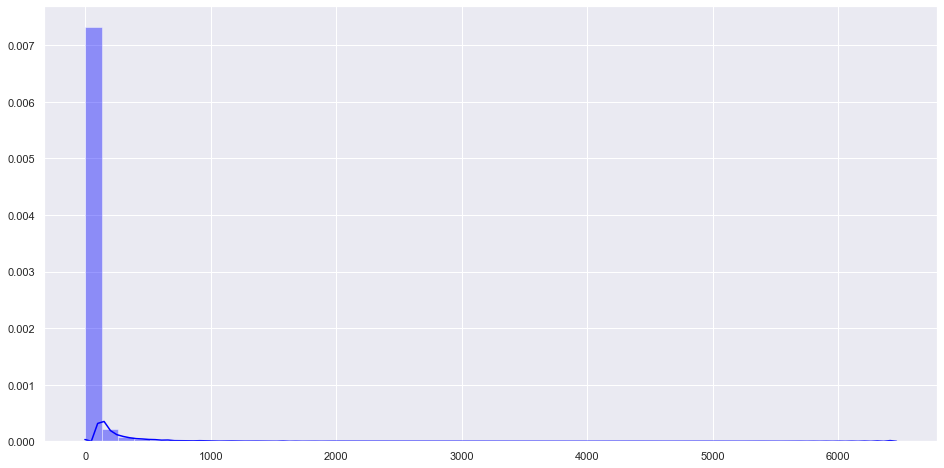

In [11]:
plt.figure(figsize=(16, 8))
sns.distplot(item_user.values, color='blue')
plt.show();

In [12]:
item_user.mean()

34.58734127976439

In [13]:
item_user[item_user > item_user.mean()].size

12094

In [14]:
item_user[item_user > item_user.mean()*2].size

6994

In [15]:
user_item.mean()

1.6160177279507315

In [16]:
user_item[user_item > user_item.mean()].size

380241

In [17]:
user_item[user_item > 50].size

456

Создаем и сохраняем сокращенный датасет

In [18]:
user_ids = user_item[user_item > 50].index.to_list()
item_ids = item_user[item_user > item_user.mean()].index.to_list()

df_reduced = df[(df['user'].isin(user_ids)) & (df['item'].isin(item_ids))]

In [19]:
df_reduced

,item,user,rating
timestamp,,,
942883200,B00001IVB4,A57Q87B0TC9IJ,5
943574400,B00002CF9G,A57Q87B0TC9IJ,1
949881600,B000040OEH,A57Q87B0TC9IJ,5
957312000,B00000K4BU,A1PID2MT8MMPAF,5
961286400,B00000K4MC,A3V6Z4RCDGRC44,5
...,...,...,...
1536278400,B01GW8YDLK,A35042IWDE456Y,5
1536364800,B01GW8YDLK,A3KDACX6N22P2J,5
1536624000,B01ESA0W3C,A31H1ECKRMHRRQ,4


In [20]:
df_reduced.to_csv(r'data/video_games_reduced.csv')

## ML

Воспользуемся реализацией алгоритма сингулярного разложения разреженной матрицы с заполнением пропусков градиентным спуском из библиотеки surprise

In [21]:
from scipy.sparse import csr_matrix

from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [22]:
df = pd.read_csv(r'data/video_games_reduced.csv', index_col='timestamp')

In [23]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

Ищем лучшие гиперпараметры модели

In [24]:
param_grid = {'n_factors': [100, 200, 300, 500], 
              'n_epochs': [100], 
              'lr_all': [0.01, 0.02],
              'reg_all': [0.005, 0.01]}

In [25]:
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-1)

In [26]:
grid_search_svd.fit(data)
find_algo = grid_search_svd.best_estimator['rmse']
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:   42.6s remaining:   14.1s
0.9848172258877511
{'n_factors': 300, 'n_epochs': 100, 'lr_all': 0.02, 'reg_all': 0.01}
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


RMSE < 1. Результат довольно неполохой. 

In [27]:
cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True, n_jobs=-1);

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9605  0.9949  0.9650  0.9897  0.9981  0.9816  0.0157  
Fit time          13.29   13.29   13.27   13.24   13.17   13.25   0.04    
Test time         0.04    0.04    0.03    0.03    0.03    0.03    0.01    


По результатам кросс-валидации делаем вывод, что модель не переобучается

Итоговое обучение и тестирование модели

In [28]:
best_params = {
    'n_factors': 100,
    'n_epochs': 100,
    'lr_all': 0.02,
    'reg_all': 0.01
}

In [29]:
trainset = data.build_full_trainset()

algo = SVD(**best_params)
algo.fit(trainset);

In [30]:
sample = df[['user', 'item']].sample().values[0]
user = sample[0]
item = sample[1]
print(algo.predict(user, item));

user: A2TCG2HV1VJP6V item: B0009SQFGQ r_ui = None   est = 4.97   {'was_impossible': False}


Следующими 2-мя действиями я получаю значения предсказания оценок для каждой пары (пользователь, товар), которых еще не было.

Нормального способа, как получить вектор товаров и оценок для одного определенного пользователя, я не нашел для данной реализации.

In [31]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [32]:
with open(r'data/predictions.csv', 'w') as f:
    f.write('user,item,rating\n')
    for prediction in predictions:
        f.write(f'{prediction.uid},{prediction.iid},{prediction.est}\n')

In [2]:
df_pred = pd.read_csv(r'data/predictions.csv')

Топ 5 рекомендаций для определенного пользователя

In [42]:
import json

print(json.dumps(json.loads(df_pred[df_pred['user'] == 'A103KKI1Y4TFNQ'].sort_values('rating', ascending=False)[['item', 'rating']].head(5).to_json(orient='records')), indent=4))

[
    {
        "item": "B01GW8YDLK",
        "rating": 5.0
    },
    {
        "item": "B019QGFNIC",
        "rating": 5.0
    },
    {
        "item": "B006IOAHTQ",
        "rating": 5.0
    },
    {
        "item": "B00WTI3JPE",
        "rating": 5.0
    },
    {
        "item": "B01C7L07OI",
        "rating": 5.0
    }
]


In [30]:
df_pred[df_pred['user'] == 'A103KKI1Y4TFNQ'].sort_values('rating', ascending=False).groupby('user')

Находим лучшую рекомендацию для каждого пользователя

In [35]:
df_pred.groupby('user').rating.agg(['max', 'idxmax']).merge(df_pred, left_on='idxmax', right_index=True)[['max', 'item']]

,max,item
user,,
A103KKI1Y4TFNQ,5.000000,B0000296O5
A10L7QIDE9UF11,5.000000,B00000K4MC
A10UUYDN5NY2GB,5.000000,B00004KHB7
A114TMHW9GRMPB,4.987175,B0002SQ0BS
A119Q9NFGVOEJZ,5.000000,B000040OEH
...,...,...
AY3Y9ROK6LRPI,5.000000,B002RD6MV4
AYFXX888CUGA0,5.000000,B00004KHB7
AYQIQLTJMPHF1,5.000000,B000040OEH


In [47]:
import json

print(json.dumps(json.loads(df_pred.groupby('user').rating.agg(['max', 'idxmax']).merge(df_pred, left_on='idxmax', right_index=True)[['item', 'max']].sample(10).rename({'max':'rating'}, axis=1).to_json(orient='index')), indent=4))

{
    "A5JLAU2ARJ0BO": {
        "rating": 4.641959019,
        "item": "B006WQR3GA"
    },
    "A3UDCUZJ29W5ZZ": {
        "rating": 5.0,
        "item": "B000040OEH"
    },
    "A3SP37JLGH5KFY": {
        "rating": 5.0,
        "item": "B00004YRQ9"
    },
    "A3S1YIQQW7AZO": {
        "rating": 5.0,
        "item": "B00005NZ1G"
    },
    "ASWHAWQ4Q1NF7": {
        "rating": 5.0,
        "item": "B000040OEH"
    },
    "AVMNNN989FKDC": {
        "rating": 5.0,
        "item": "B000A2R54M"
    },
    "AYFXX888CUGA0": {
        "rating": 5.0,
        "item": "B00004KHB7"
    },
    "A1O72D7RLAMMLX": {
        "rating": 5.0,
        "item": "B00001IVB4"
    },
    "A2GVVAO242EK1D": {
        "rating": 5.0,
        "item": "B00000K125"
    },
    "A238IX6INYRVX4": {
        "rating": 5.0,
        "item": "B00009WAUO"
    }
}
